In [1]:
#!/usr/bin/env python
# coding: utf-8

# Created by Noel Naughton (nnaught2@illinois.edu) on Oct. 16, 2018
# Import microstructure, pulse sequence and DTI metrics from LBM solution of B-T equation for dMRI
# and generate randomforest model

# This first cell imports data into panda dataframe and gets it ready to be used by the meta-model.
# It is self-contained and can be copied directly to other programs. 

# chaospy is an opensource package for implentation of polynomial chaos methods
# here it is used to fit a polynomial model using Least Squares Regression
# chaospy can be installed via: pip install chaospy
# documentation is at https://chaospy.readthedocs.io/en/master/
# extract data to numpy arrays
# import libraries

# Code sucesfully runs with pip packages from Fall 2019. More recent package updates may not be compatible. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import chaospy as cp
from SALib.sample import saltelli
from SALib.analyze import sobol


filename = '_DTI_results_all.csv'
dti_metrics = pd.read_csv(filename)
DTI_indices = dti_metrics[['FA','MD','RD','L1','L2','L3']]

DTI_indices.MD*=1e9
DTI_indices.RD*=1e9
DTI_indices.L1*=1e9
DTI_indices.L2*=1e9
DTI_indices.L3*=1e9

problem = {
            'num_vars': 7,
    
            'names': ['diameter ', 
                      'packing  ', 
                      'perm     ', 
                      'Din      ', 
                      'Dex      ', 
                      'b-value  ',
                      'diff_time'],
    
            'bounds': [[10e-6, 80e-6 ], # diameter
                      [0.70  , 0.95  ], # volume fraction
                      [10e-6 , 100e-6], # permeability
                      [0.5e-9, 2.5e-9], # Din
                      [0.5e-9, 2.5e-9], # Dex
                      [300e6, 1200e6],  # b-value
                      [0.0100, 0.750]], # Diffusion Time

            'names_clean': ['Diameter', 
                            'Volume\nFraction', 
                            'Permeability', 
                            'Intracellular\nDiffusion', 
                            'Extracellular\nDiffusion', 
                            'B-Value',
                            'Diffusion\nTime']
            }

lst = ['FA','MD','RD','L1','L2','L3']

lst_clean = ['Fractional Anisotropy',
            'Mean Diffusivity',
            'Radial Diffusivity',
            'Primary Eigenvalue',
            'Secondary Eignenvalue',
            'Tertiary Eigenvalue']

param_values = saltelli.sample(problem, 5000)
print(param_values.shape)


############################################
inputs_unscaled = param_values

## If inputs were scaled to order 1
input_scaled = inputs_unscaled*[1e6,1e2,1e6,1e10,1e10,1e-7,1e2]
inputs = input_scaled.T


/var/folders/xw/p65h4vbd6lbbj3wz66d4vkxw0000gn/T/ipykernel_54235/2645905210.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DTI_indices.MD*=1e9
/var/folders/xw/p65h4vbd6lbbj3wz66d4vkxw0000gn/T/ipykernel_54235/2645905210.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DTI_indices.RD*=1e9
/var/folders/xw/p65h4vbd6lbbj3wz66d4vkxw0000gn/T/ipykernel_54235/2645905210.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

(80000, 7)


In [2]:
'''
    Load the polynomial meta-models for the different polynomial orders
'''

global meta_model
meta_model = {}

order = '3_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']
] =  pickle.load( open('pickled_metamodels_3_new_new.pkl', 'rb'), encoding='latin1')[0]

order = '4_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']
] =  pickle.load( open('pickled_metamodels_4_new_new.pkl', 'rb'), encoding='latin1')[0]

order = '5_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']
] =  pickle.load( open('pickled_metamodels_5_new_new.pkl', 'rb'), encoding='latin1')[0]

order = '6_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']
] =  pickle.load( open('pickled_metamodels_6_new_new.pkl', 'rb'), encoding='latin1')[0]

order = '7_order'
meta_model[order]= {}
[meta_model[order]['FA'], meta_model[order]['MD'], meta_model[order]['RD'], 
 meta_model[order]['L1'], meta_model[order]['L2'], meta_model[order]['L3']
] =  pickle.load( open('pickled_metamodels_7_new_new.pkl', 'rb'), encoding='latin1')[0]

In [3]:
# Sanity check the accuracy of one of the entries against a LBM simulation results to make sure 
# things are scaled and matching up correctly.

dMRI_keys = ['FA','MD','RD','L1','L2','L3']
DTI_values = {}
DTI_range = {}
for val in dMRI_keys:
    DTI_range[val] = DTI_indices[val].max() - DTI_indices[val].mean() #DTI_indices[val].mean()

## Sanity check
i = 0
m, ordr = 'L1', '7_order'
# size_err
mod = meta_model[ordr][m]
eval_temp = mod(inputs[0][i],inputs[1][i],inputs[2][i],
                inputs[3][i],inputs[4][i],inputs[5][i],inputs[6][i])
print('Meta-model result:',eval_temp)
print('LBM simulation:   ',DTI_indices[m][i])
print('Relative Error:    %2.4f %%' % (abs(eval_temp - DTI_indices[m][i])/(DTI_range[m])*100))


Meta-model result: 1.614741116619279
LBM simulation:    1.6039706609719502
Relative Error:    1.0538 %


In [9]:
# check average error against the values used to fit the polynomial
import time
import multiprocessing as mp

start = time.time()

order_keys = ['3_order','4_order','5_order','6_order','7_order']
dMRI_keys = ['FA','MD','RD','L1','L2','L3']

DTI_values = {}
DTI_range = {}
for val in dMRI_keys:
    DTI_values[val] = DTI_indices[val].values
    DTI_range[val] = DTI_indices[val].max() - DTI_indices[val].mean() 
    
size, num = (param_values.shape[0], problem['num_vars'])
split = int(size*0.70)
size_err = size-split
err = {}

from check_error import check_error, init_worker

print('starting pool')
pool = mp.Pool(10, initializer=init_worker, initargs=(meta_model,))

# order_keys = ['7_order']
start_all = time.time()
for order in order_keys:
    print(order)
    err[order] = {}
    start = time.time()
    for val in ['FA', 'MD', 'RD', 'L1', 'L2', 'L3']:
        # print(val)
        args = tuple(
            [(inputs[:,i+split], order, val, DTI_indices[val][i+split], DTI_range[val]
             ) for i in range(0,size_err)])
        err[order][val] = pool.map( check_error, args )
    end = time.time()
    print(order, 'finished in', (end - start), 'seconds')
    
pool.close()
pool.join()

end = time.time()
print((end - start_all)/60, 'minutes')


starting pool
3_order
3_order finished in 21.377427101135254 seconds
4_order
4_order finished in 58.584057092666626 seconds
5_order
5_order finished in 135.19695687294006 seconds
6_order
6_order finished in 296.7398102283478 seconds
7_order
7_order finished in 609.8192420005798 seconds
18.698319697380064 minutes


In [15]:

def plot_results(main_lim=1.0, sec_lim = 1.0, yticks=4):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_style("ticks")
    
    fig, axes = plt.subplots(2,3,figsize=(10*1.5, 5*1.5))        
    xtitle = ['FA', 'MD', 'RD', '$\lambda_1$', '$\lambda_2$', '$\lambda_3$']
    for pl, val in enumerate(['FA', 'MD', 'RD', 'L1', 'L2', 'L3']):
        R = pl % 2 
        C = math.floor(pl/2)

        ax = axes[R,C]
        err_plot = []
        for order in order_keys:
            err_plot.append(err[order][val] )
    
        if val == 'MD' or val == 'L1':
            maxval = 2.5
        else:
            maxval = 5.0
    
        err_plot = np.array(err_plot)* DTI_range_old[val]/DTI_range_new[val]
    
        leg_lab = ['3rd-order', '4th-order', '5th-order','6th-order', '7th-order']
    
        weights = np.ones_like(err_plot[0])/float(len(err_plot[0]))
        
        bins = np.arange(0,maxval + maxval/5.,maxval/5.)
        xlab = ['Cell Diameter', 'Packing Fraction', 'Permeability', 'Intracellular Diffusion', 'Extracellular Diffusion']

        
        # libraries & dataset
        import seaborn as sns
        import matplotlib.pyplot as plt
        # set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
        sns.set(style="white")
  
        multipl = 'stack'
        fig = sns.kdeplot(err_plot[4], fill=True,  ax=ax, label = leg_lab[4], multiple=multipl, levels=50)
        fig = sns.kdeplot(err_plot[3], fill=True,  ax=ax, label = leg_lab[3], multiple=multipl, levels=50)
        fig = sns.kdeplot(err_plot[2], fill=True,  ax=ax, label = leg_lab[2], multiple=multipl, levels=50)
        fig = sns.kdeplot(err_plot[1], fill=True,  ax=ax, label = leg_lab[1], multiple=multipl, levels=50)
        fig = sns.kdeplot(err_plot[0], fill=True,  ax=ax, label = leg_lab[0], multiple=multipl, levels=50)

        xlabels = [str(np.round(b,2)) for b in bins[1:]]
        xlabels[-1] += '+'
        for i in range(0,5):     
            xlabels[i] += '%'
        N_labels = len(xlabels)
        ax.set_xlim([-maxval, maxval])
        if val == 'MD' or val == 'L1':
            ax.set_ylim([0, sec_lim+0.05])
            ytick = np.linspace(0,1.0, yticks+1) * sec_lim
            ax.set_yticks(ytick) 
            ax.set_xticks(np.array([-4, -2.0, 0., 2.0, 4.0])/2)
        else:
            ax.set_ylim([0, main_lim+0.05])
            ytick = np.linspace(0,1.0, yticks+1) * main_lim
            ax.set_yticks(ytick) 
            ax.set_xticks([-4, -2.0, 0., 2.0, 4.0])

        if pl == 0:
            ax.legend(loc='upper right', fontsize = 14,frameon=False)
        ax.set_xlabel('%s Relative Error' % xtitle[pl], size = 16)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        ax = plt.gca()
        sns.despine()
    plt.tight_layout()
    plt.show()


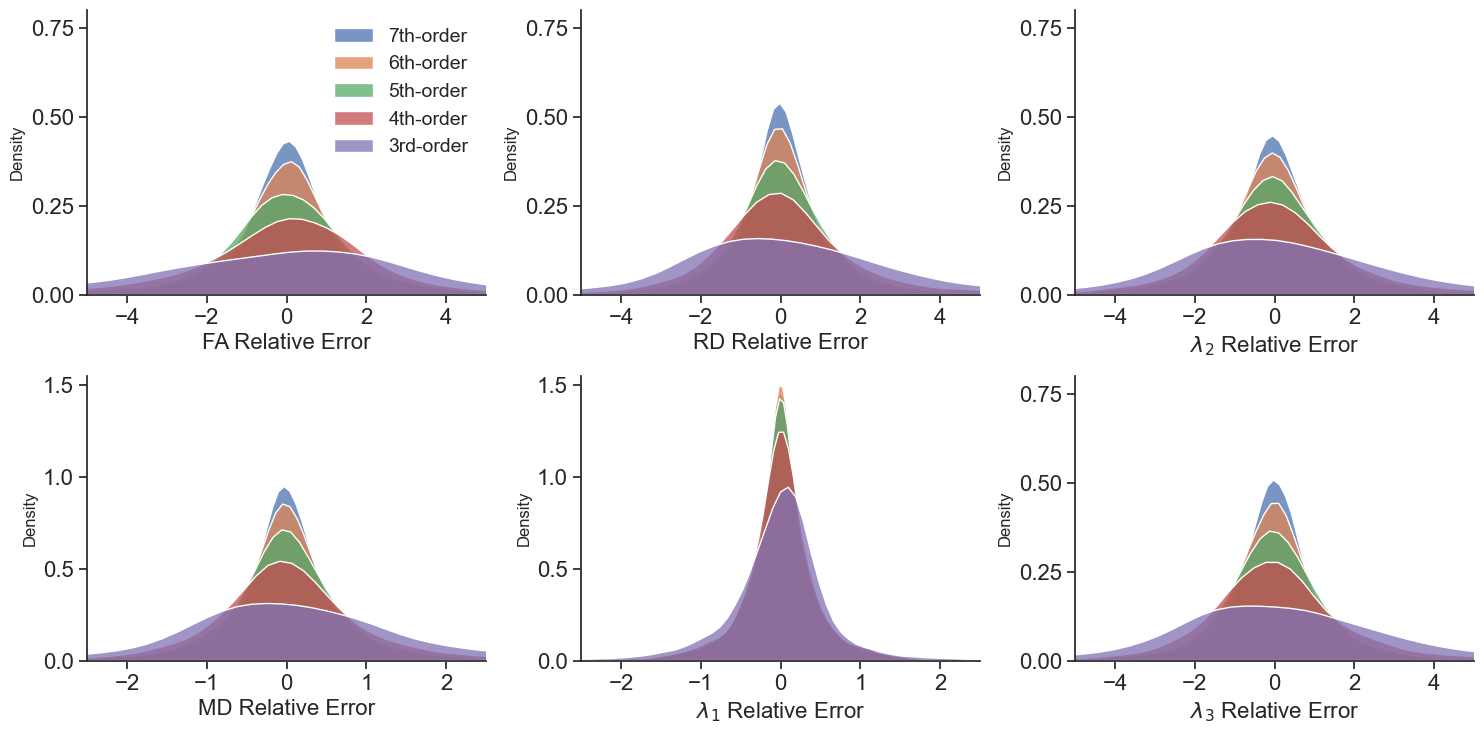

In [16]:
DTI_range_old = DTI_range
DTI_range_new = {}
for val in dMRI_keys:
    DTI_range_new[val] = DTI_indices[val].mean() 


plot_results(main_lim=0.75, sec_lim = 1.5,yticks=3)
